In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
import torch.nn as nn
import random
import torch.nn.functional as F
import pandas as pd
import spacy
import torch.optim as optim
import numpy as np
import scipy
import torch
from collections import defaultdict
from collections import Counter
from transformers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

In [3]:
#load data and spacy
df = pd.read_csv('IMDB_Dataset.csv')
nlp = spacy.load("en_core_web_sm")

# BINARY not text
for i, row in df.iterrows():
    if row["sentiment"] == "positive":
        df.at[i,'sentiment'] = 1
    else:
        df.at[i,'sentiment'] = 0

In [ ]:
def sent_hist():
    explore_data = list()
    for i,rev in enumerate(df.sample(n = 50000, replace = False)["review"]):
        if i % 500 == 0:
            print(i)
        sents = list()
        doc=nlp(rev, disable = ["ner", "tagger"])
        for j,sent in enumerate(doc.sents):
            sents.append(sent)
        explore_data.append(sents)
    lengths = list()
    for l in explore_data:
        lengths.append(len(l))
    lengths
    plt.hist(lengths, range=(0,50), bins=25)
    plt.show()


In [4]:
def create_train():
    train_mini = list()
    for i,rev in enumerate(df["review"]):
        if i % 10000 == 0:
            print(i)
        sents = list()
        doc=nlp(rev, disable = ["ner", "tagger"])
        for j,sent in enumerate(doc.sents):
            if j == 15: # avg length of sents
                break
            sents.append(str(sent))
        train_mini.append(sents)
    return train_mini
tm = create_train()

0
10000
20000
30000
40000


In [5]:
def clean(data):
    clean_data = list()
    for review in data:
        clean_sents = list()
        for sent in review:
            doc = nlp(sent, disable = ["ner", "parser", "tagger"])
            tokens = list()
            for token in doc:
                if token.is_alpha and not token.is_stop and len(token.text) > 2:
                    tokens.append(token.lemma_.lower())
            if len(tokens) > 0:
                clean_sents.append(" ".join(tokens)) 
        clean_data.append(clean_sents)
    return clean_data
clean = clean(tm)

In [ ]:
def freq_dist(text):
    all_words = list()
    for rev in clean:
        for sent in rev:
            for word in sent.split(" "):
                all_words.append(word)
    freq = Counter(all_words)
    words = freq.most_common(len(all_words))
    freq_axis = list()
    for word, freq in words:
        freq_axis.append(freq)
    x = np.arange(0, len(freq_axis), 1)
    plt.xlim(0,15000)
    plt.ylim(0,800)
    plt.plot(x, freq_axis)
    plt.show()
freq_dist(clean)

In [6]:
def make_voc(data, max_size = 10000):
    vocab = defaultdict(int)
    vocab["<pad>"] = 0
    all_words = list()
    word_id = 1
    for rev in data:
        for word in " ".join(rev).split(" "):
            all_words.append(word)
    freq = Counter(all_words)
    words = freq.most_common(max_size - len(vocab))
    word_id = 1
    for word,freq in words:
        vocab[word] += word_id
        word_id += 1
    return vocab

In [7]:
vocab_freq = make_voc(clean)


In [8]:
def prepare_sequence(seq, vocab):
    idxs = [vocab[w] if w in vocab else 0 for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [11]:
def prep_train(data):
    train = list()
    for rev in data:
        sents = list()
        for sent in rev:
            sents.append(prepare_sequence(sent.split(" "), vocab_freq))
        train.append(sents)
    return train

In [12]:
#not mini anymore

train_mini = prep_train(clean)
sent_mini = np.array(df["sentiment"], dtype=np.int64)

In [13]:
class lstm_vectorizer(nn.Module):

    def __init__(self, embedding_dim=512, hidden_dim=256, vocab_size=10000):
        super(lstm_vectorizer, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = 2, bidirectional = True)


    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        
        embeds = embeds.to("cuda")

        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        
        lstm_out = lstm_out.to("cuda")
        
        #hidden = self.hidden(lstm_out)
        return torch.mean(lstm_out.squeeze(1), axis=0) # torch.mean(hidden, axis=0)
    

In [20]:
class MLP(nn.Module): 
    def __init__(self, embdim = 512, hidden_unit = 128, output_dim = 2):
        super().__init__()
        self.hidden = nn.Linear(15 * embdim, hidden_unit) #hidden_unit
        self.activate = nn.ReLU()
        self.output = nn.Linear(hidden_unit, output_dim)

    def forward(self, features):
        hn = self.hidden(features)
        act = self.activate(hn)
        out = self.output(act) 
        
        return out  

In [66]:
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = lstm_vectorizer()
        self.mlp = MLP()

    def forward(self, review):
        #need 10 outputs concat
        lstm_vector = [self.lstm.forward(sent.to("cuda")) for sent in review]
        #print(lstm_vector[0].shape)
        lstm_vector.extend([torch.FloatTensor(512 *[0]).to("cuda")] * (15 - len(lstm_vector))) # padding
        input_mlp = torch.cat(lstm_vector).to("cuda")
        input_mlp = input_mlp.to("cuda")
        output_mlp = self.mlp.forward(input_mlp)
        output_mlp = output_mlp.to("cuda")
        return output_mlp

net = net()

In [67]:
def train_net(model, revs, sents):
    loss_function = nn.NLLLoss()
    optimizer = AdamW(model.parameters(), lr=1e-3)
    m = nn.LogSoftmax(dim=1)
    
    for epoch in range(1):
        p = 0
        for i, rev in enumerate(revs[:10000]):
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            
            target = torch.tensor([sents[i]])
            target = target.to("cuda")

            # Step 3. Run our forward pass.
            forward = model(rev)
            forward = forward.to("cuda")
            
            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(m(forward.unsqueeze(0)), target)
            loss.backward()
            optimizer.step()
            if i % 500 == 0:
                p+=10
                print("loss:", loss.item())
                print(p,"% ...")

In [68]:
net = net.to("cuda")
start_net = time.time()
train_net(net, train_mini, sent_mini)
stop_net = "{:.2f}".format(time.time() - start_net)
print(stop_net)

loss: 0.6548235416412354
10 % ...
loss: 0.6614212989807129
20 % ...
loss: 0.054835811257362366
30 % ...
loss: 0.0024085817858576775
40 % ...
loss: 0.469472199678421
50 % ...
loss: 0.12319814413785934
60 % ...
loss: 0.007120352238416672
70 % ...
loss: 0.16713280975818634
80 % ...
loss: 0.8927990198135376
90 % ...
loss: 0.025480687618255615
100 % ...
loss: 0.21253739297389984
110 % ...
loss: 0.03808215260505676
120 % ...
loss: 0.02404201775789261
130 % ...
loss: 0.2340904325246811
140 % ...
loss: 2.6940935640595853e-05
150 % ...
loss: 0.015620498917996883
160 % ...
loss: 0.04955741763114929
170 % ...
loss: 0.7524333596229553
180 % ...
loss: 0.16573046147823334
190 % ...
loss: 0.06546764075756073
200 % ...
399.14


0.854

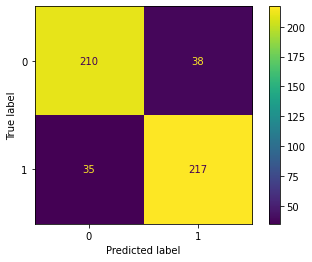

In [63]:
preds = list()
#sample from two different 
for rev in train_mini[-500:]:
    with torch.no_grad():
        scores = net(rev)
        probs = torch.exp(scores)
        preds.append(torch.argmax(probs.unsqueeze(0), dim=1)[0].item())

golds = sent_mini[-500:]
golds = golds.astype(int)
accuracy_score(golds, preds)
cm = confusion_matrix(golds, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
accuracy_score(golds, preds)

### LSTM  

In [3]:
#some cleaning

for i, row in df.iterrows():
    if i % 10000 == 0:
        print(i)
    doc = nlp(row["review"], disable = ["ner", "parser", "tagger"])
    rev = list()
    for token in doc:
        if token.is_alpha and not token.is_stop and len(token.text) > 2:
            rev.append(token.lemma_.lower())
    df.at[i,"review"] = " ".join(rev)
            
        
    

0
10000
20000
30000
40000


In [4]:
def make_vocab(df, max_size = 10000):
    vocab = defaultdict(int)
    vocab["<unk>"] = 0
    print(vocab)
    # do counter
    #get most common
    #put in dict. 
    all_words = list()
    word_id = 1
    for i, row in df.iterrows():
        if i % 10000 == 0:
            print(i)
        for word in row["review"].split(" "):
            all_words.append(word)
    freq = Counter(all_words)
    words = freq.most_common(max_size - len(vocab))
    print(len(words))
    word_id = 1
    for word,freq in words:
        vocab[word] += word_id
        word_id += 1
    return vocab
vocab = make_vocab(df)

defaultdict(<class 'int'>, {'<unk>': 0})
0
10000
20000
30000
40000
9999


In [5]:
def prepare_sequence(seq, vocab):
    idxs = [vocab[w] if w in vocab else 0 for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


#### prep training data and class

In [6]:
train_rev = list()
word_sents = list()
for i, rev in enumerate(df["review"].to_numpy()):
    word_sents.append(rev.split(" ")) # for lr
    train_rev.append(prepare_sequence(rev.split(" "), vocab)) # for lstm
train_sent = df["sentiment"].to_numpy()


In [80]:
class LSTMclassifier(nn.Module):

    def __init__(self, embedding_dim = 256, hidden_dim = 100, vocab_size = 10000):
        super(LSTMclassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = 2, bidirectional = True)
        self.out = nn.Linear(2 * hidden_dim, 2)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        embeds = embeds.to("cuda")
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        lstm_out = lstm_out.to("cuda")
        out = self.out(lstm_out) #lstm_out[-1]
        out = torch.mean(out, axis=0)
        out = out.to("cuda")
        return out

In [88]:
def train_lstm(model, revs, sents):
    loss_function = nn.NLLLoss()
    optimizer = AdamW(model.parameters(), lr=1e-3)
    m = nn.LogSoftmax(dim=1)

    for epoch in range(2):  # again, normally you would NOT do 300 epochs, it is toy data
        p = 0
        for i, rev in enumerate(revs):
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.

            target = torch.tensor([sents[i]])
            target = target.to("cuda")
            rev = rev.to("cuda")
            # Step 3. Run our forward pass.
            predict = model(rev)
            
            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(m(predict), target)
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                p+=1
                #print("loss:", loss.item())
                #print(p,"% ...")
    return model
#train_lstm(lstm, train_rev, train_sent)

In [ ]:
m = nn.LogSoftmax(dim=1)
beg = 20000
end = 20500
preds = list()
for rev in train_rev[beg:end]:
    with torch.no_grad():
        first = train_rev[2]
        rev = rev.to("cuda")
        scores = lstm(rev)
        probs = torch.exp(m(scores))
        preds.append(torch.argmax(probs, dim=1)[0].item())

        
golds = train_sent[beg:end]
golds = golds.astype(int)
accuracy_score(golds, preds)
cm = confusion_matrix(golds, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
accuracy_score(golds, preds)
    

### Baseline model logistic regression

In [43]:
# tfidf
corpus = list(df["review"])
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
X_tf_train = torch.tensor(scipy.sparse.csr_matrix.todense(X[:26000])).float()

In [44]:
X = X_tf_train

In [7]:
# bow 
def make_bow_vector(sentence, vocab):
    vec = torch.zeros(len(vocab))
    for word in sentence:
        if word in vocab:
            vec[vocab[word]] += 1
        else:
            vec[0] += 1
    return vec.view(1, -1)

In [8]:
class lr(nn.Module): 

    def __init__(self, num_labels, vocab_size):

        super(lr, self).__init__()


        self.linear = nn.Linear(vocab_size, num_labels)

    def forward(self, rev):

        out = self.linear(rev)
        out = out.to("cuda")
        return out
#lr = lr(2, len(vocab))
#lr = lr(2, 84183)
#lr = lr.to("cuda")

In [55]:
def train_lr_tf(model, word_sents, sentiment):
    m = nn.LogSoftmax(dim=1)
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    p = 0
    for epoch in range(2):  
        for i, rev in enumerate(word_sents):
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()
            rev = rev.to("cuda")
            target = torch.tensor([sentiment[i]])
            target = target.to("cuda")
            predict = model(rev) 
            loss = loss_function(m(predict.unsqueeze(0)), target)
            loss.backward()
            optimizer.step()
            if i % 2450 == 0:
                p+=10
                #print("loss:", loss.item())
                #print(p,"% ...")
        return model

In [41]:
def train_lr_bow(model, train, sentiment, vocab):
    m = nn.LogSoftmax(dim=1)
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    p = 0
    for epoch in range(2):  
        for i, rev in enumerate(train):
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()
            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            bow_rev = make_bow_vector(rev, vocab)
            target = torch.tensor([sentiment[i]])
            target = target.to("cuda")
            bow_rev = bow_rev.to("cuda")
            # Step 3. Run our forward pass.
            predict = model(bow_rev) #bow_rev
            
            loss = loss_function(m(predict), target)
            loss.backward()
            optimizer.step()
            if i % 500 == 0:
                p+=10
                #print("loss:", loss.item())
                #print(p,"% ...")
    return model
#train_lr(lr, word_sents, train_sent, vocab)


### Prediction functions

In [81]:
def lrbow_preds(model, test_data, size=500):
    m = nn.LogSoftmax(dim=1)
    preds = list()
    for rev in test_data[:size]:
        with torch.no_grad():
            inp = make_bow_vector(rev, vocab)
            inp = inp.to("cuda")
            out = model(inp)
            probs = torch.exp(m(out))
            preds.append(torch.argmax(probs, dim=1)[0].item())
    return preds

def lrtf_preds(model, test_data, size=500):
    m = nn.LogSoftmax(dim=1)
    preds = list()
    for rev in test_data[:size]:
        with torch.no_grad():
            rev = rev.to("cuda")
            out = model(rev)
            probs = torch.exp(m(out.unsqueeze(0)))
            preds.append(torch.argmax(probs, dim=1)[0].item())
    return preds


def lstm_preds(model, test_data, size=500):
    m = nn.LogSoftmax(dim=1)
    preds = list()
    for rev in test_data[:size]:
        with torch.no_grad():
            rev = rev.to("cuda")
            out = model(rev)
            probs = torch.exp(m(out))
            preds.append(torch.argmax(probs, dim=1)[0].item())
    return preds

def net_preds(model, test_data, size=500):
    

def lrbow_acc(golds, preds, size=500):
    golds = golds.astype(int)
    score = accuracy_score(golds[:size], preds)
    cm = confusion_matrix(golds[:size], preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    return score

In [ ]:
m = nn.LogSoftmax(dim=1)

beg = 9500
end = 10000
preds = list()
for rev in word_sents[beg:end]:
    with torch.no_grad():
        inp = make_bow_vector(rev, vocab)
        inp = inp.to("cuda")
        out = lr(inp)
        probs = torch.exp(m(out))
        preds.append(torch.argmax(probs, dim=1)[0].item())

golds = train_sent[beg:end]
preds
golds = golds.astype(int)
accuracy_score(golds, preds)
cm = confusion_matrix(golds, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
accuracy_score(golds, preds)

## TESTS

In [84]:
x_bow5000_train, x_bow5000_test, y_bow5000_train, y_bow5000_test = train_test_split(word_sents, train_sent, test_size=0.90, random_state=42)
x_bow10000_train, x_bow10000_test, y_bow10000_train, y_bow10000_test = train_test_split(word_sents, train_sent, test_size=0.8, random_state=42)
x_bow25000_train, x_bow25000_test, y_bow25000_train, y_bow25000_test = train_test_split(word_sents, train_sent, test_size=0.5, random_state=42)

x_lstm5000_train, x_lstm5000_test, y_lstm5000_train, y_lstm5000_test = train_test_split(train_rev, train_sent, test_size=0.90, random_state=42)
x_lstm10000_train, x_lstm10000_test, y_lstm10000_train, y_lstm10000_test = train_test_split(train_rev, train_sent, test_size=0.8, random_state=42)
x_lstm25000_train, x_lstm25000_test, y_lstm25000_train, y_lstm25000_test = train_test_split(train_rev, train_sent, test_size=0.5, random_state=42)




In [50]:
x_tfidf5000_train = X[:5000]
y_tfidf5000_train = train_sent[:5000]
x_tfidf5000_test = X[25000:25500]
y_tfidf5000_test = train_sent[25000:25500]

x_tfidf10000_train = X[:10000]
y_tfidf10000_train = train_sent[:10000]
x_tfidf10000_test = X[25000:25500]
y_tfidf10000_test = train_sent[25000:25500]

x_tfidf25000_train = X[:25000]
y_tfidf25000_train = train_sent[:25000]
x_tfidf25000_test = X[25000:25500]
y_tfidf25000_test = train_sent[25000:25500]

### LR BOW TESTER

bow_5k time: 19.17
bow_5k acc: 0.766
#############################
bow_10k time: 38.20
bow_10k acc: 0.81
#############################
bow_25k time: 95.91
bow_25k acc: 0.84


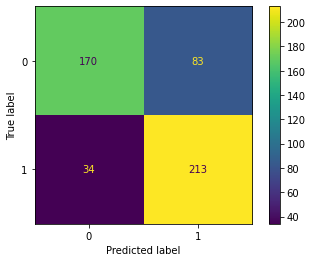

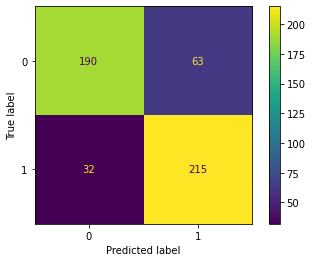

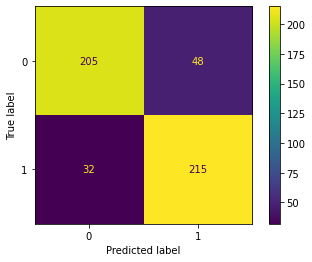

In [42]:
# split data - ALL data
# call all models, get preds and golds
# collect and check acc and times

#time each model and report accuracy on unseen data
import time
start_5000 = time.time()
lr_bow_5000 = lr(2, len(vocab))
lr_bow_5000 = lr_bow_5000.to("cuda")
lr_bow_5000 = train_lr_bow(lr_bow_5000, x_bow5000_train, y_bow5000_train, vocab)
lr_bow_time_5000 = "{:.2f}".format(time.time() - start_5000)
print("bow_5k time:",lr_bow_time_5000)
preds_5000 = lrbow_preds(lr_bow_5000, x_bow5000_test)
#TODO ACC LOOP AVG 10 on 500 random
lr_bow_5000_acc = lrbow_acc(y_bow5000_test, preds_5000)
print("bow_5k acc:",lr_bow_5000_acc)
print("#############################")

start_10000 = time.time()
lr_bow_10000 = lr(2, len(vocab))
lr_bow_10000 = lr_bow_10000.to("cuda")
lr_bow_10000 = train_lr_bow(lr_bow_10000, x_bow10000_train, y_bow10000_train, vocab)
lr_bow_time_10000 = "{:.2f}".format(time.time() - start_10000)
print("bow_10k time:",lr_bow_time_10000)
preds_10000 = lrbow_preds(lr_bow_10000, x_bow10000_test)
lr_bow_10000_acc = lrbow_acc(y_bow10000_test, preds_10000)
print("bow_10k acc:",lr_bow_10000_acc)
print("#############################")

start_25000 = time.time()
lr_bow_25000 = lr(2, len(vocab))
lr_bow_25000 = lr_bow_25000.to("cuda")
lr_bow_25000 = train_lr_bow(lr_bow_25000, x_bow25000_train, y_bow25000_train, vocab)
lr_bow_time_25000 = "{:.2f}".format(time.time() - start_25000)
print("bow_25k time:",lr_bow_time_25000)
preds_25000 = lrbow_preds(lr_bow_25000, x_bow25000_test)
lr_bow_25000_acc = lrbow_acc(y_bow25000_test, preds_25000)
print("bow_25k acc:",lr_bow_25000_acc)

### LR TFIDF TESTER

tfidf_5k time: 3.43
tfidf_5k acc: 0.734
#############################
tfidf_10k time: 7.98
tfidf_10k acc: 0.86
#############################
tfidf_25k time: 20.38
tfidf_5k acc: 0.87
#############################


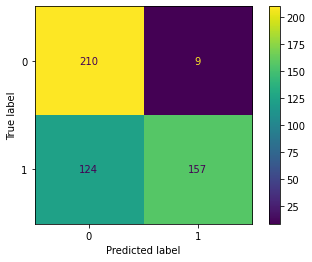

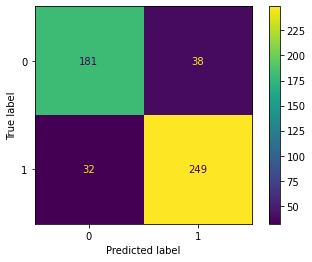

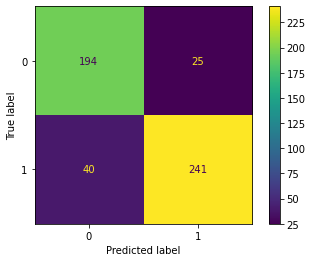

In [74]:
# split data - ALL data
# call all models, get preds and golds
# collect and check acc and times

#time each model and report accuracy on unseen data
import time
start_5000 = time.time()
lr_tfidf_5000 = lr(2, 84183)
lr_tfidf_5000 = lr_tfidf_5000.to("cuda")
lr_tfidf_5000 = train_lr_tf(lr_tfidf_5000, x_tfidf5000_train, y_tfidf5000_train)
lr_tfidf_time_5000 = "{:.2f}".format(time.time() - start_5000)
print("tfidf_5k time:",lr_tfidf_time_5000)
tfidf_preds_5000 = lrtf_preds(lr_tfidf_5000, x_tfidf5000_test)
#TODO ACC LOOP AVG 10 on 500 random
lr_tfidf_5000_acc = lrbow_acc(y_tfidf5000_test, tfidf_preds_5000)
print("tfidf_5k acc:",lr_tfidf_5000_acc)
print("#############################")

start_10000 = time.time()
lr_tfidf_10000 = lr(2, 84183)
lr_tfidf_10000 = lr_tfidf_10000.to("cuda")
lr_tfidf_10000 = train_lr_tf(lr_tfidf_10000, x_tfidf10000_train, y_tfidf10000_train)
lr_tfidf_time_10000 = "{:.2f}".format(time.time() - start_10000)
print("tfidf_10k time:",lr_tfidf_time_10000)
tfidf_preds_10000 = lrtf_preds(lr_tfidf_10000, x_tfidf10000_test)
#TODO ACC LOOP AVG 10 on 500 random
lr_tfidf_10000_acc = lrbow_acc(y_tfidf10000_test, tfidf_preds_10000)
print("tfidf_10k acc:",lr_tfidf_10000_acc)
print("#############################")

start_25000 = time.time()
lr_tfidf_25000 = lr(2, 84183)
lr_tfidf_25000 = lr_tfidf_25000.to("cuda")
lr_tfidf_25000 = train_lr_tf(lr_tfidf_25000, x_tfidf25000_train, y_tfidf25000_train)
lr_tfidf_time_25000 = "{:.2f}".format(time.time() - start_25000)
print("tfidf_25k time:",lr_tfidf_time_25000)
tfidf_preds_25000 = lrtf_preds(lr_tfidf_25000, x_tfidf25000_test)
#TODO ACC LOOP AVG 10 on 500 random
lr_tfidf_25000_acc = lrbow_acc(y_tfidf25000_test, tfidf_preds_25000)
print("tfidf_25k acc:",lr_tfidf_25000_acc)
print("#############################")

### LSTM TEST

lstm_5k time: 142.49
lstm_5k acc: 0.82
#############################
lstm_5k time: 435.13
lstm_5k acc: 0.854
#############################
lstm_25k time: 739.92
lstm_5k acc: 0.882
#############################


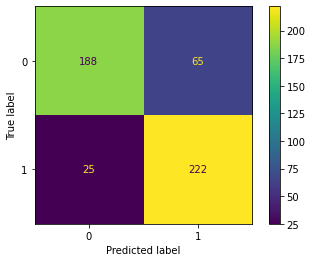

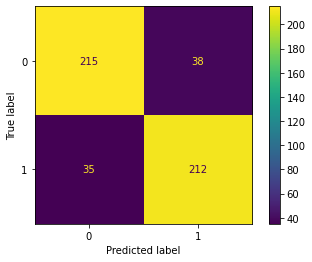

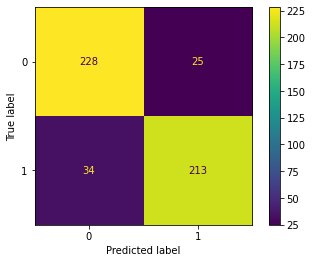

In [90]:
# split data - ALL data
# call all models, get preds and golds
# collect and check acc and times

#time each model and report accuracy on unseen data
import time
start_5000 = time.time()
lstm_5000 = LSTMclassifier()
lstm_5000 = lstm_5000.to("cuda")
lstm_5000 = train_lstm(lstm_5000, x_lstm5000_train, y_lstm5000_train)
lstm_time_5000 = "{:.2f}".format(time.time() - start_5000)
print("lstm_5k time:",lstm_time_5000)
lstm_preds_5000 = lstm_preds(lstm_5000, x_lstm5000_test)
#TODO ACC LOOP AVG 10 on 500 random
lstm_5000_acc = lrbow_acc(y_lstm5000_test, lstm_preds_5000)
print("lstm_5k acc:",lstm_5000_acc)
print("#############################")

start_10000 = time.time()
lstm_10000 = LSTMclassifier()
lstm_10000 = lstm_10000.to("cuda")
lstm_10000 = train_lstm(lstm_10000, x_lstm10000_train, y_lstm10000_train)
lstm_time_10000 = "{:.2f}".format(time.time() - start_5000)
print("lstm_5k time:",lstm_time_10000)
lstm_preds_10000 = lstm_preds(lstm_10000, x_lstm10000_test)
#TODO ACC LOOP AVG 10 on 500 random
lstm_10000_acc = lrbow_acc(y_lstm10000_test, lstm_preds_10000)
print("lstm_5k acc:",lstm_10000_acc)
print("#############################")

start_25000 = time.time()
lstm_25000 = LSTMclassifier()
lstm_25000 = lstm_25000.to("cuda")
lstm_25000 = train_lstm(lstm_25000, x_lstm25000_train, y_lstm25000_train)
lstm_time_25000 = "{:.2f}".format(time.time() - start_25000)
print("lstm_25k time:",lstm_time_25000)
lstm_preds_25000 = lstm_preds(lstm_25000, x_lstm25000_test)
#TODO ACC LOOP AVG 10 on 500 random
lstm_25000_acc = lrbow_acc(y_lstm25000_test, lstm_preds_25000)
print("lstm_5k acc:",lstm_25000_acc)
print("#############################")

In [ ]:


net_5000
net_10000
net_25000